<a href="https://colab.research.google.com/github/snehsuresh/dogsvcats/blob/main/dogvcat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Importing Data from Kaggle

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## **tensorflow**:
This is the core library for numerical computation and machine learning. It provides a set of tools for building and training various types of machine learning models.

## **keras**:
provides an interface for building and training neural networks. In your case, you're using it as part of TensorFlow.


> **Sequential**: A *Keras class* that allows you to create a linear stack of layers, where you can add one layer at a time in a step-by-step fashion

> **Dense**: A fully connected layer. Each neuron is connected to every neuron in the previous and the next layers.

> **Conv2D**: 2D convolutional layer. Used for spatial convolution over images.

> **MaxPooling2D**: This layer performs max pooling operation for spatial data. Reduces the spatial dimensions (width and height) of the input volume.

> **Flatten**: This layer is used to flatten the input. It transforms the data into a 1D array before feeding it into the next layer (ANN).

> **BatchNormalization**: This layer normalizes the activations of the previous layer at each batch. It can improve the training speed and stability of neural networks.

>**Dropout**: Dropout is a regularization technique where randomly selected neurons are ignored during training. It helps prevent overfitting. Introduces noise.

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

We need to feed the images from train folder to our model. We can do it manually using os but since we have a lot of images, processing all of them can prove heavy on the RAM.

Keras gives us something called as **Generators**
>Divides your data into batches. One batch is loaded into RAM instead of all data.
>We will be using a generator called **image_dataset_from_directory**

In [5]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


# **Normalization**
To normalize the pixel values of the input image. We first convert(cast) the pixel values to a float32 data type using tf.cast. Then, divide each pixel value by 255.0 to scale the pixel values to the range [0, 1], to make the training process more numerically stable.

In [6]:
# Normalize
def process(image,label):
  #label could be 0 for cats and 1 for dogs
    image = tf.cast(image/255. ,tf.float32)
    print(label)
    return image,label

train_ds = train_ds.map(process) #The map method applies the specified function to each element of the dataset
validation_ds = validation_ds.map(process)

Tensor("args_1:0", shape=(None,), dtype=int32)
Tensor("args_1:0", shape=(None,), dtype=int32)


## Model Creation

>Architecture where there are 3 Convolution layers with 32,64,128 filters respectively

## Convolutional Neural Network
(CNN) model using the Sequential API in Keras (which is now integrated into TensorFlow).

> First convolutional layer with 32 filters of size 3x3.

>*'valid'* padding means no padding is added to the input.

> The activation function is ReLU (Rectified Linear Unit), a common choice for convolutional layers.

> input_shape=(256, 256, 3) specifies the shape of the input images (256x256 pixels with 3 color channels).

## Batch Normalization Layer
>Batch normalization is applied to normalize the activations of the previous layer, improving training stability and speed.

>Imagine, what if during your training one of the weights become drastically larger than the other?

>Well, this large weight will cause the output from its corresponding neuron to be extremely large. And this imbalance will again continue to cascade through the neuron network causing instability.

>**Batch Norm** is applied to layers that you choose to apply to. It normalizes the output from the activation function (to which outputs from every layers are passed).
Resulting in z.

>Batch norm then multiplies this normalized output by some arbitrary parameter and then adds another arbitrary parameter. (z * g) + b

>This sets a new std. deviation and mean for the data. These 4 parameters consisting of SD, Mean, and the two arbitrarily set parameters are all trainable. Meaning they too will be optimised during training.

> This process makes it so that the weights within the network don't become inbalance with extremely low/high values

>This increases the speed in which training occurs and reduce the influence of outlying weights that can over influence the training.

## Max Pooling
>MaxPooling with a pool size of 2x2 reduces the spatial dimensions of the input by half.

>'valid' (no padding): The pooling window stays entirely within the input boundaries, and the output size is reduced.

## Flatten Layer

>This layer flattens the output of the previous layer into a one-dimensional array, preparing it for fully connected layers.

## Dense (Fully Connected) Layers

>The role of Dense layers in a Convolutional Neural Network (CNN) is to process the high-level features learned by the convolutional layers and make a final decision or prediction

>Dense layers are fully connected layers, where each neuron is connected to every neuron in the previous layer. Let's break down the reasons for having Dense layers in this context
>> **Flattening the Spatial Features**: Before the Dense layers, there is a Flatten layer that converts the 3D output of the convolutional and pooling layers into a 1D array.

>>This is necessary because Dense layers require a one-dimensional input.
>>Learning High-Level Representations:

>>Convolutional layers are effective at learning low and mid-level features, such as edges and textures.

>>Dense layers, on the other hand, can **capture more abstract and high-level representations by combining these lower-level features**.

Dense layers aggregate information from the entire input. In the context of image classification, this means considering the global patterns and relationships between different features.

>The final layer has a single neuron with a sigmoid activation function, which is common for binary classification problems. It outputs values between 0 and 1, representing the probability of the input belonging to the positive class.

## Dropout
>Dropout is a regularization technique used to prevent overfitting in neural networks.

>The dropout layer randomly "drops out" a certain percentage of neurons during training, meaning those neurons are temporarily excluded from the forward and backward passes.

>This introduces noise and prevents the network from relying too heavily on any one neuron, improving generalization to unseen data.

In [7]:
#CNN Model
model = Sequential() #Sequential Model selection

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3))) #image is fed to this layer
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu')) #Why not 32? Typically, as you go deeper into the network, the number of neurons in Dense layers may increase to capture more abstract and high-level features. The earlier layers (Conv2D with 32 filters) focus on learning simple and local features, while deeper layers can learn more complex and global patterns.
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [8]:
model.summary()

# Read the text block below first
# 256 -> convo output reduces 2-> 254 -> max pooling halves it -> 127 -> convo output reduces 2 -> 125 -> repeat

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

# Model Summary


## Layer Information
- Each layer is represented in the summary with its type (e.g., Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout), a unique name (automatically assigned unless specified), and additional details.

## Output Shape
- The `(None, ...)` represents the batch size (which is flexible during training and can be different for each batch) and the shape of the output tensor after each layer.

## Parameter Count (Param #)
- This indicates the number of trainable parameters in each layer. Trainable parameters are the weights and biases that the model learns during training. For example, in Conv2D layers, the parameters include the convolutional kernel weights and biases. The sum of all the weights and biases in a neural network are collectively referred to as the "parameters" of the network. So if param is x, that means model learns x number of weights and biases.

## Total Parameters
- The total number of trainable parameters in the entire model is given at the bottom. This includes parameters from all layers.

## Trainable Parameters and Non-Trainable Parameters
- The trainable parameters are those that will be updated during training to minimize the loss function. Non-trainable parameters are fixed and not updated during training. For example, in BatchNormalization layers, there are trainable parameters (gamma and beta) and non-trainable parameters (moving mean and moving variance).

## Layer Details
- **Conv2D Layer (conv2d)**
  - Output Shape: (None, 254, 254, 32)
  - None: This dimension corresponds to the batch size. During training, the neural network processes data in batches, and the batch size is flexible (it can vary from batch to batch). The "None" here indicates that the batch size is not fixed at this point in the model summary.

  - 254, 254: These two dimensions represent the spatial dimensions of the output. In a Conv2D layer, each filter (there are 32 filters in this case) processes the input image, and the spatial dimensions of the output are determined by the size of the convolutional kernel and the padding. Here, the output has a spatial size of 254x254 pixels.
    -Output = [(Input - Kernel or filter Size + 2 * Padding)/stride] + 1

    - Input is 256 (height and breadth]
    - Kernel or Filter size:3(assuming a 3×3 convolutional kernel)
    - Padding: 0
    - Stride: 1
    - Do the calculation and output would be 254
    - So, the output spatial dimensions are 254 x 254. This reduction in spatial size is a result of applying a 3 times 3 convolutional kernel to the input image without any padding. **Each application of the kernel reduces the size of the feature map by 2 pixels in both dimensions**.

  - 32: This dimension represents the number of channels in the output. In the context of Conv2D layers, each filter produces a separate channel in the output, and there are 32 filters applied in this layer. Each channel represents a different feature or pattern that the filter has learned to detect.
    - In the context of neural networks, especially convolutional neural networks (CNNs), a "channel" refers to a dimension in the input or output data. In the context of image data, each channel often represents a specific feature or aspect of the data.

    - For example, in the case of RGB (Red, Green, Blue) images, each image has three color channels: one for red values, one for green values, and one for blue values. Each channel is a two-dimensional array (a matrix) representing the intensity of the corresponding color across the image.

    - The term "channel size" refers to the number of such channels. For RGB images, the channel size is 3, as there are three color channels. In a grayscale image, there is only one channel, representing the intensity of the grayscale values.

    - In the context of Conv2D layers in a CNN, the channel size typically corresponds to the number of filters or kernels applied in that layer. Each filter is responsible for learning different features in the input data, and the number of filters determines the number of output channels. The output tensor of a convolutional layer has a shape of (height, width, channels).


  - Parameters: 896 (weights and biases)

- **BatchNormalization Layer (batch_normalization)**
  - Output Shape: (None, 254, 254, 32)
  - Parameters: 128 (gamma, beta, moving mean, moving variance)

- **MaxPooling2D Layer (max_pooling2d)**
  - Output Shape: (None, 127, 127, 32)
  - No additional parameters (pooling is a non-parametric operation)

## Trainable and Non-trainable

So the more non-trainable params me have the worse our model gets?
- The impact of non-trainable parameters on the performance of a model depends on various factors, including the nature of the task, the complexity of the data, and the architecture of the neural network. Having non-trainable parameters is not inherently bad; it depends on how they are used and whether they contribute positively to the model's ability to generalize and make accurate predictions.

- BatchNormalization and Stability: Non-trainable parameters, such as moving mean and moving variance in BatchNormalization layers, are often used to stabilize training by normalizing input data. This can be beneficial for convergence and generalization.

In [9]:
#Compile Model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
# import time
# import pandas as pd

# epochs = 10
# total_elapsed_time = 0
# epoch_times = []

# for epoch in range(epochs):
#     # Record start time for the current epoch
#     epoch_start_time = time.time()

#     # Fit the model for one epoch
#     history = model.fit(train_ds, epochs=1, validation_data=validation_ds)

#     # Record end time for the current epoch
#     epoch_end_time = time.time()

#     # Calculate elapsed time for the current epoch
#     epoch_elapsed_time = epoch_end_time - epoch_start_time

#     # Accumulate total elapsed time
#     total_elapsed_time += epoch_elapsed_time

#     # Record epoch number and time taken
#     epoch_times.append({'Epoch': epoch + 1, 'Time Taken': epoch_elapsed_time})

# # Create a DataFrame for printing a table
# epoch_times_df = pd.DataFrame(epoch_times)

# # Print the table
# print(epoch_times_df)
# print(f"Total time for {epochs} epochs: {total_elapsed_time} seconds.")


In [11]:
import time

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Training took {elapsed_time} seconds.")


Epoch 1/10
625/625 [==============================] - 75s 108ms/step - loss: 1.4622 - accuracy: 0.5569 - val_loss: 0.6544 - val_accuracy: 0.6114
Epoch 2/10
625/625 [==============================] - 66s 104ms/step - loss: 0.6352 - accuracy: 0.6428 - val_loss: 0.6339 - val_accuracy: 0.6422
Epoch 3/10
625/625 [==============================] - 66s 105ms/step - loss: 0.5477 - accuracy: 0.7233 - val_loss: 0.5470 - val_accuracy: 0.7202
Epoch 4/10
625/625 [==============================] - 68s 108ms/step - loss: 0.4723 - accuracy: 0.7740 - val_loss: 0.4586 - val_accuracy: 0.7844
Epoch 5/10
625/625 [==============================] - 67s 107ms/step - loss: 0.4141 - accuracy: 0.8092 - val_loss: 0.4588 - val_accuracy: 0.7902
Epoch 6/10
625/625 [==============================] - 64s 102ms/step - loss: 0.3553 - accuracy: 0.8418 - val_loss: 0.4542 - val_accuracy: 0.8042
Epoch 7/10
625/625 [==============================] - 67s 107ms/step - loss: 0.3019 - accuracy: 0.8642 - val_loss: 0.4973 - val_ac

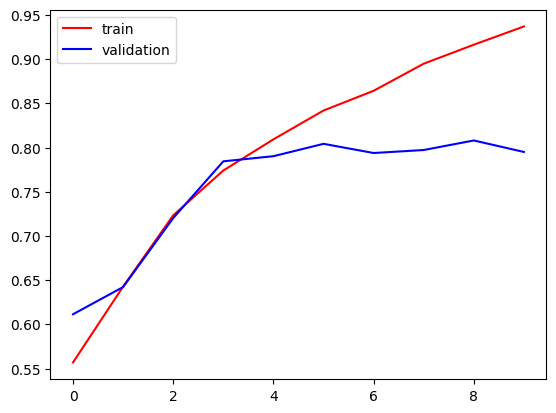

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

Training accuracy increases till 95 but the validation accuracy stalls around 80. This tells you somewhere overfitting is happening.

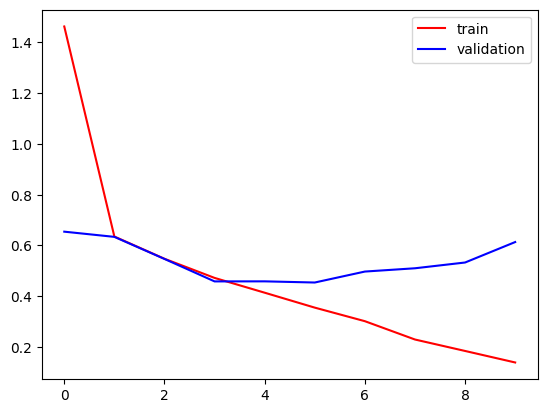

In [14]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

As epochs increase, training loss is decreasing, but validation loss stalls around 0.6. An indication of overfitting.

##How to reduce overfitting?
### Add more data
### Data Augmentation -> next video
### L1/L2 Regularizer
### Dropout
### Batch Norm
### Reduce complexity

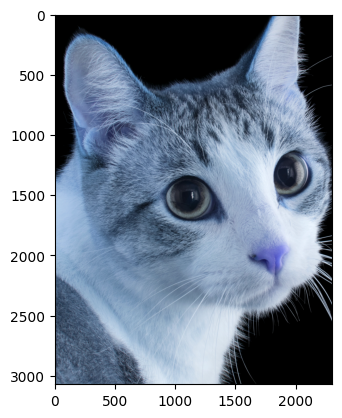

In [29]:
import cv2
test_img = cv2.imread('/content/cat2.webp')
plt.imshow(test_img)

In [30]:
test_img.shape
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))
model.predict(test_input)

1/1 [==============================] - 0s 23ms/step


array([[0.]], dtype=float32)